# Pyteomics ms data reader

The tool is adapted from [Link to the Github](https://github.com/pymzml/pymzML)

The whole workflow should cite 

```
M Kösters, J Leufken, S Schulze, K Sugimoto, J Klein, R P Zahedi, M Hippler, S A Leidel, C Fufezan; pymzML v2.0: introducing a highly compressed and seekable gzip format, Bioinformatics, doi: https://doi.org/10.1093/bioinformatics/bty046
```

The Introduction is [Here](https://pyteomics.readthedocs.io/en/latest/data.html#mzml-and-mzxml)

In [1]:
import pyteomics
from pyteomics import mzml, auxiliary
import matplotlib.pyplot as plt
import numpy as np
import math
import plotly.graph_objects as go
import re
from scipy.integrate import simps
import pandas as pd

from progressbar import ProgressBar
pbar = ProgressBar()

import peakutils
from peakutils.plot import plot as pplot
from matplotlib import pyplot

In [2]:
%matplotlib inline

In [3]:
#Read mzml files
f=mzml.MzML('../example_data/20191210_MSpos_tl_frac_B7_F5_narrow_2_noSPE.mzML')

In [4]:
#The data structure is a mzml list contains scans as dictionary and titles
#Could iterate for the MS1/MS2 spectrums
#f[i] #where i is the index

#Get the scan time--Data structure is complex
f[0]['scanList']['scan'][0]['scan start time']

0.044816666667 minute

In [16]:
#TIC plot
def tic_plot(spectrum, interactive=True):
    '''
    Static tic plot function
    '''
    time=[]
    TIC=[]
    for i in range(len(spectrum)):
        time.append(spectrum[i]['scanList']['scan'][0]['scan start time'])
        TIC.append(spectrum[i]['total ion current'])
    
    if interactive == True:
        fig = go.Figure([go.Scatter(x=time, y=TIC,
                        hovertemplate = 'Int: %{y}' + '<br>RT: %{x}minute<br>')])

        fig.update_layout(
            template = 'simple_white',
            width = 1000,
            height = 600,
            xaxis = {'title':'Retention Time (min)'},
            yaxis = dict(
                showexponent = 'all',
                exponentformat = 'e',
                title = 'Intensity'))

        fig.show()
    
    elif interactive == False:
        plt.figure(figsize=(10,6))
        plt.plot(time,TIC)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.xlabel('RT (min)')
        plt.ylabel('TIC')
        plt.title('TIC spectrum')
        plt.show()
    
    return

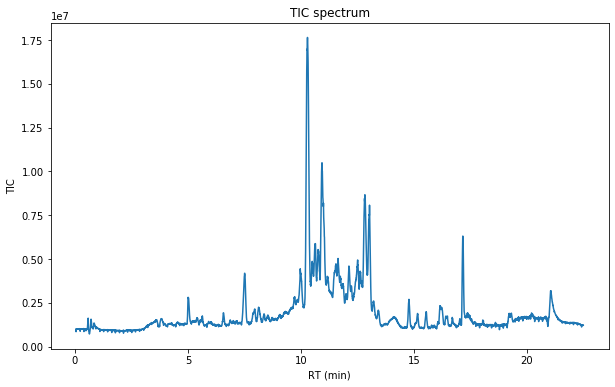

In [17]:
tic_plot(f, False)

In [19]:
def ms_plot(spectrum, time, interactive=False):
    '''
    Interactive spectrum plot with nearest retention time from the given time
    '''
    for i in range(len(spectrum)):
        if spectrum[i]['scanList']['scan'][0]['scan start time'] >= time:
            mz = f[i]['m/z array']
            ints = f[i]['intensity array']
            rt = spectrum[i]['scanList']['scan'][0]['scan start time']
            break
    
    if interactive == True:        
        fig = go.Figure([go.Bar(x=mz, y=ints, marker_color = 'red', width = 0.5,
                        hovertemplate =
                        'Int: %{y}'+
                        '<br>m/z: %{x}<br>')])
        fig.update_layout(
                title_text=str(round(rt, 3)) + ' min MS1 spectrum, input '+ str(time) + ' min',
                template = 'simple_white',
                width = 1000,
                height = 600,
                xaxis = {'title':'m/z ratio'},
                yaxis = dict(
                    showexponent = 'all',
                    exponentformat = 'e',
                    title = 'Intensity'))
        fig.show()
    
    elif interactive == False:
        plt.figure(figsize=(10,5))
        plt.bar(mz, ints, width = 1.0)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.xlabel('m/z')
        plt.ylabel('Intensity')
        plt.title('MS1 spectrum')
    
    return

In [21]:
ms_plot(f, 15, True)

In [25]:
#Quick trail for try except
test = [1,2,3,'wow',5]
for i in test:
    try:
        i += 1
        print(i)
    except:
        print('wrong type')

2
3
4
wrong type
6


In [26]:
def mz_locator(input_list, mz, error):
    '''
    Find specific mzs from given mz and error range
    input list: mz list
    '''
    target_mz = []
    target_index = []
    
    lower_mz = mz - error
    higher_mz = mz + error

    for i, mzs in enumerate(input_list):
        if mzs < lower_mz:
            continue
        elif mzs >= lower_mz:
            if mzs <= higher_mz:
                target_mz.append(mzs)
                target_index.append(i)
        elif mzs > higher_mz:
                target_mz = 0
                target_index = 'NA'
                break
        
    return target_mz, target_index

In [32]:
def formula_mass(input_formula, mode = 'pos'):
    '''
    sudo code:
    convert input string into a list with element:number structure
    convert all the element into upper case
    match the string list into a given list of element weight
    add adduct/delete H according to mode -- also have neutral mode
    '''
    #Define a list
    elist = {'C': 12, 
            'H':1.00782,
            'N':14.0031,
            'O':15.9949,
            'S':31.9721,
            'P':30.973763,
            'e':0.0005485799}
    
    mol_weight = 0
    parsed_formula = re.findall(r'([A-Z][a-z]*)(\d*)', input_formula)
    for element_count in parsed_formula:
        element = element_count[0]
        count = element_count[1]
        if count == '':
            count = 1
        
        mol_weight += elist[element]*float(count)
    
    if mode == 'pos':
        mol_weight += elist['e'] + elist['H']
    elif mode == 'neg':
        mol_weight -= elist['e'] + elist['H']
    else:
        pass
    
    return mol_weight

In [29]:
def ms_chromatogram(ms_file, input_mz, error, smooth=False, mode='pos', interactive=True):
    '''
    Interactive chromatogram for selected m/z
    '''
    if type(input_mz) == float:
        pass
    elif type(input_mz) == int:
        pass
    elif type(input_mz) == str:
        input_mz = formula_mass(input_mz, mode)
    else:
        print('Cant recognize input type!')
    
    
    
    retention_time = []
    intensity = []
    for i in range(len(ms_file)):
        #print(i)
        retention_time.append(ms_file[i]['scanList']['scan'][0]['scan start time'])
        
        target_mz, target_index = mz_locator(ms_file[i]['m/z array'], input_mz, error)
        if target_index == 'NA':
            intensity.append(0)
        else:
            intensity.append(sum(ms_file[i]['intensity array'][target_index]))

    def peak_smooth(input_list, baseline=500):
        for i, int_ in enumerate(input_list):
            if i > 1 and i < len(input_list)-3:
                if int_ > baseline:
                    for index in np.arange(i+1,i+3):
                        if input_list[index] == 0:
                            input_list[index] = (input_list[index-1]+input_list[index+1])/2
                        else:
                            continue
            
    if smooth == True:
        peak_smooth(intensity)

    if interactive == True:
        fig = go.Figure([go.Scatter(x=retention_time, y=intensity,
                    hovertemplate = 'Int: %{y}' + '<br>RT: %{x}minute<br>')])

        fig.update_layout(
            title_text=str(round(input_mz, 2)) + ' chromatogram, error '+ str(error),
            template = 'simple_white',
            width = 1000,
            height = 600,
            xaxis = {'title':'Retention Time (min)'},
            yaxis = dict(
                showexponent = 'all',
                exponentformat = 'e',
                title = 'Intensity'))

        fig.show()
    elif interactive == False:
        plt.figure(figsize=(20,10))
        plt.plot(retention_time, intensity)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.xlabel('m/z')
        plt.ylabel('Intensity')
        plt.title('MS1 spectrum')
        plt.xlim(0,retention_time[-1])
        plt.ylim(0,)
        plt.show()
    return

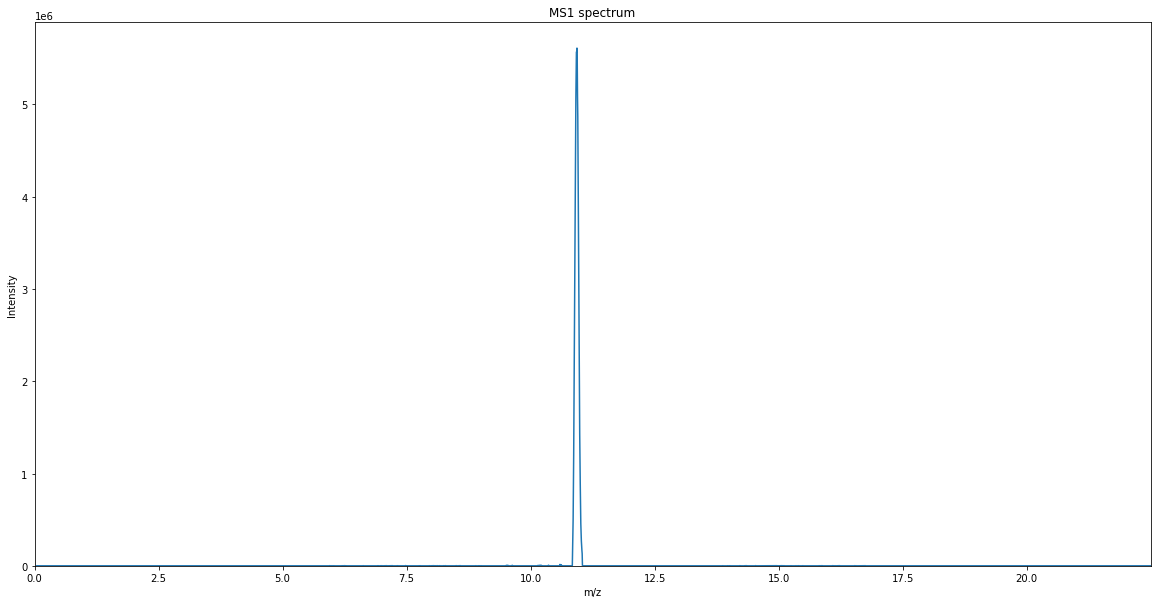

In [34]:
ms_chromatogram(f, 'C18H22N2O2', 0.002, False, 'pos',False)

In [40]:
def ms_chromatogram_list(ms_file, input_mz, error, baseline = 5000):
    '''
    Generate a peak list for specific input_mz over whole rt period from the mzml file
    ***Most useful function!
    '''
    retention_time = []
    intensity = []
    for i in range(len(ms_file)):
        #print(i)
        retention_time.append(ms_file[i]['scanList']['scan'][0]['scan start time'])
        
        target_mz, target_index = mz_locator(ms_file[i]['m/z array'], input_mz, error)
        if target_index == 'NA':
            intensity.append(0)
        else:
            intensity.append(sum(ms_file[i]['intensity array'][target_index]))
    
    for i, ints in enumerate(intensity):
        if ints < baseline:
            intensity[i] = 0
            
    return retention_time, intensity

In [35]:
def peak_pick(rt, intensity, peak_base = 5000, thr = 0.02, min_d = 1, rt_window = 1.5, peak_area_thres = 1e5, min_scan = 7, max_scan = 200):
    '''
    rt, ints from ms_chromatogram_list
    rt_window now set up for minutes
    '''
    #Get rt_window corresponded scan number
    scan_window = int((rt_window / (rt[int(len(intensity) / 2)] - rt[int(len(intensity) / 2) - 1])) / 2)
    
    #Get peak index
    indexes = peakutils.indexes(intensity, thres=thr, min_dist = min_d)
    
    result_dict = {}
    
    for index in indexes:
        h_range = index
        l_range = index
        base_intensity = peak_base

        #Get the higher and lower boundary
        while intensity[h_range] >= base_intensity:
            h_range += 1
            if h_range > len(intensity)-2:
                break
        while intensity[l_range] >= base_intensity:
            l_range -= 1
        #Output a range from the peak list
        
        peak_range = []
        if h_range - l_range >= min_scan:
            if rt[h_range] - rt[l_range] <= rt_window:
                peak_range = intensity[l_range:h_range]
            else:
                l_range = index - scan_window
                h_range = index + scan_window
                peak_range = intensity[l_range:h_range]
                #print(index + scan_window)

        #Intergration based on the simps function
        if len(peak_range) >= min_scan:
            integration_result = simps(peak_range)
            if integration_result >= peak_area_thres:
                result_dict.update({index : [l_range, h_range, integration_result]})


    return result_dict

In [36]:
def integration_plot(rt, ints, peak_base = 0.005, thr = 0.02, min_d = 1, rt_window = 2, peak_area_thres = 1e5):
    
    result_dict = peak_pick(rt, ints)
    
    plt.figure(figsize=(20,10))
    plt.plot(rt, ints)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlabel('m/z')
    plt.ylabel('Intensity')
    plt.title('Integration result')
    plt.xlim(0,rt[-1])
    plt.ylim(0,)
    
    for index in result_dict:
        print('Peak retention time: {:0.2f} minute, Peak area: {:0.1f}'.format(rt[index], result_dict[index][2]))
        plt.fill_between(rt[result_dict[index][0] : result_dict[index][1]], ints[result_dict[index][0] : result_dict[index][1]])
        
    
    return

In [37]:
rt, ints = ms_chromatogram_list(f, 299.5, 0.5, 5000)

In [38]:
peak_pick(rt,ints)

{1971: [1836, 2106, 103051257.6245702], 2187: [2052, 2322, 10174437.061920164]}

Peak retention time: 10.94 minute, Peak area: 103051257.6
Peak retention time: 12.13 minute, Peak area: 10174437.1


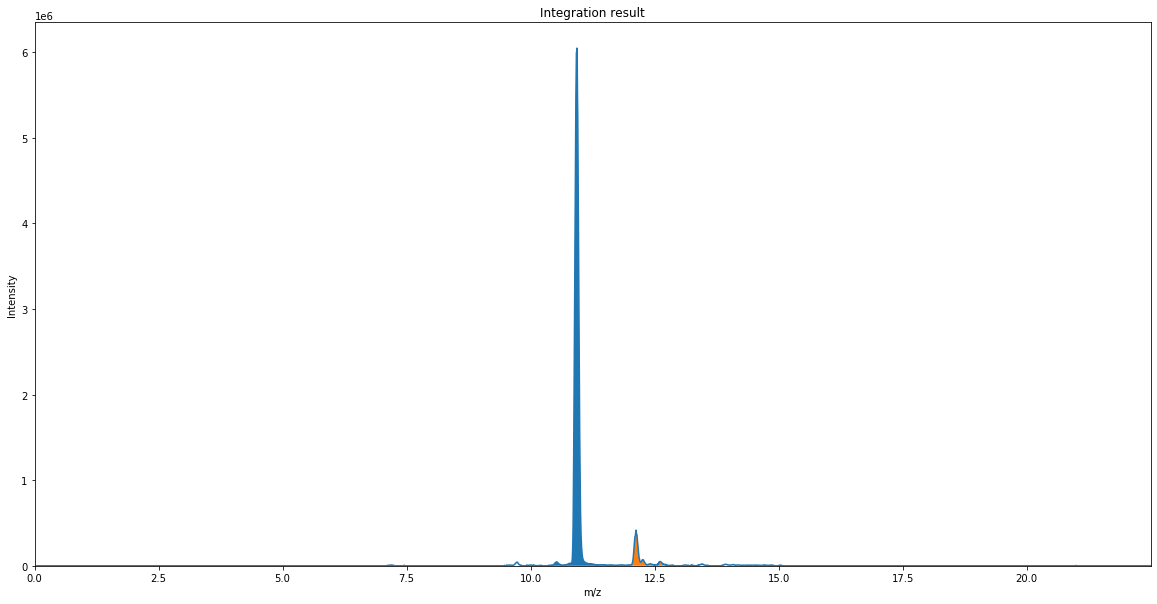

In [39]:
integration_plot(rt, ints)

In [100]:
test_mz = []
for i in range(len(f_5000)):
    test_mz.append(f_5000[i]['m/z array'])

In [101]:
from pandas.core.common import flatten
test_mz1 = list(flatten(test_mz))

In [102]:
len(test_mz1)

167212

In [30]:
test_mz2 = list(set([test_mz1[i] for i in range(len(test_mz1))]))

In [31]:
len(test_mz2)

5850369

(array([1625565., 1541724., 1118478.,  691811.,  341692.,  239235.,
         164036.,   92597.,   25021.,   12776.]),
 array([ 100.00446902,  259.85703297,  419.70959691,  579.56216085,
         739.41472479,  899.26728874, 1059.11985268, 1218.97241662,
        1378.82498056, 1538.67754451, 1698.53010845]),
 <a list of 10 Patch objects>)

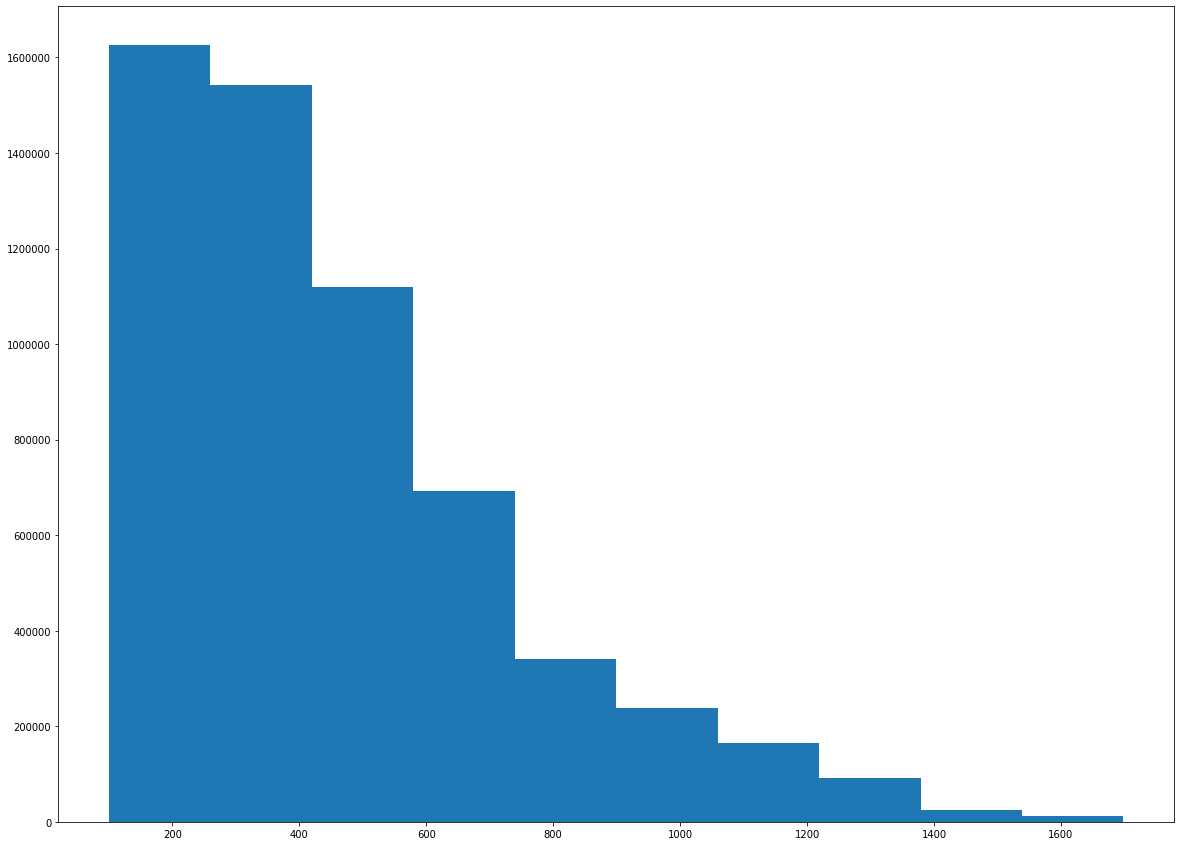

In [32]:
plt.figure(figsize=(20,15))
plt.hist(test_mz1)

In [90]:
min_mz = f_5000[0]['m/z array'].min()
max_mz = f_5000[0]['m/z array'].max()
for i in f_5000:
    if min_mz > i['m/z array'].min():
        min_mz = i['m/z array'].min()
    if max_mz < i['m/z array'].max():
        max_mz = i['m/z array'].max()

In [106]:
error = 0.002
i_list = []
i = min_mz + error
while i <= max_mz:
    i_list.append(i)
    i += 2 * error

In [114]:
df = pd.DataFrame(columns = ['1','2','3'])

In [124]:
f_5000[0]['rt']

0.044816666667 minute

In [126]:
f_5000[0]

{'rt': 0.044816666667 minute,
 'm/z array': array([102.01367676, 116.0288353 , 116.97698964, 121.05087307,
        125.98645302, 130.00767676, 132.00253036, 134.03955512,
        141.95882267, 143.03881604, 144.02730353, 149.00248667,
        151.03596862, 158.00317563, 159.00867819, 160.03657603,
        167.01307518, 172.97791679, 179.9907935 , 182.98547743,
        183.98963188, 184.99287855, 194.11746625, 922.00984305,
        923.01228999]),
 'int array': array([24845.76953125, 15832.95800781,  7756.72851562, 80570.203125  ,
        32532.18554688, 20537.1171875 ,  5970.92675781, 31309.3203125 ,
        69042.21875   , 31342.86914062,  8355.87402344,  9984.08300781,
         7059.43164062, 77905.1328125 ,  5589.57324219,  6814.87597656,
         9779.85449219, 16208.9765625 ,  6000.21630859, 55517.46875   ,
         5031.50341797,  6894.69091797, 16772.53125   , 61597.54296875,
        10749.83300781])}

In [45]:
def ms1_baseline(spectrum, baseline):
    '''
    Remove noises, then remove void features from the whole list
    Note that this function now only works on MS1 data, no filter is applied on MS2 data, code needs to be updated in the future
    '''
    #Make a copy of spectrum
    spec = spectrum
    rt_dict = []
    
    for i in range(len(spec)):
        int_list = spec[i]['intensity array']
        mz_list = spec[i]['m/z array']
        idxs = [(index, ints) for index, ints in enumerate(int_list) if ints < baseline]
        drop_idxs = [idx[0] for idx in idxs]
        
        int_list = [i for j, i in enumerate(int_list) if j not in drop_idxs]
        mz_list = [i for j, i in enumerate(mz_list) if j not in drop_idxs]
        
        int_array = np.array(int_list)
        mz_array = np.array(mz_list)
        rt = spec[i]['scanList']['scan'][0]['scan start time']
        
        current_dict = {'rt' : rt, 'm/z array' : mz_array, 'int array' : int_array}
        
        rt_dict.append(current_dict)
        #peaklist=list(zip(mz_list, int_list))
        #rt_dict.update({spec[i]['scanList']['scan'][0]['scan start time'] : peaklist})
    
    return rt_dict

In [46]:
f_5000 = ms1_baseline(f, 5000)

In [47]:
#Main dev issue
def peak_list(baseline_list, mz_error, peak_base = 0.005, thr = 0.02, min_d = 1, rt_window = 1.5, peak_area_thres = 1e5, min_scan = 7, scan_thres = 7):
    '''
    input from ms1_baseline function
    Q to solve: how to correctly select mz slice?? see mz_locator
    '''
    
    #Get m/z range
    def mz_list(spec):
        min_mz = spec[0]['m/z array'].min()
        max_mz = spec[0]['m/z array'].max()
        for i in spec:
            if min_mz > i['m/z array'].min():
                min_mz = i['m/z array'].min()
            if max_mz < i['m/z array'].max():
                max_mz = i['m/z array'].max()
        
        mz_list = []
        mz = min_mz + mz_error
        while mz <= max_mz:
            mz_list.append(mz)
            mz += 2 * mz_error
            
        return mz_list
    
    def ms_chromatogram_list(ms_file, input_mz, error, baseline = 5000):
        retention_time = []
        intensity = []
        for scan in ms_file:
            #print(i)
            retention_time.append(scan['rt'])

            target_mz, target_index = mz_locator(scan['m/z array'], input_mz, error)
            if target_index == 'NA':
                intensity.append(0)
            else:
                intensity.append(sum(scan['int array'][target_index]))

        for i, ints in enumerate(intensity):
            if ints < baseline:
                intensity[i] = 0

        return retention_time, intensity
    
    mzlist = mz_list(baseline_list)
    
    result_dict = {}
    
    for mz in pbar(mzlist):
        try:
            rt, intensity = ms_chromatogram_list(baseline_list, mz, mz_error)
            if len(intensity) >= scan_thres:
                peak_dict = peak_pick(rt, intensity, peak_base = 0.005, thr = 0.02, min_d = 1, rt_window = 1.5, peak_area_thres = 1e5, min_scan = 7)
        except:
            pass
        
        if len(peak_dict) != 0:
            
            #Note: next to solve : how to deal with replicate items, i,e #3809
            #Note2: how to deal with baseline noise i,e ms_chromatogram_list1(f_5000, 102.01360767939408, 0.002)
            for index in peak_dict:
                result_dict.update({'m/z' : mz,
                                    'rt' : rt[index],
                                    'peak area' : peak_dict[index][2]})
    
    d_result = pd.DataFrame(result_dict)
    
    return d_result

In [ ]:
peak_list(f_5000, 0.002)

In [10]:
    def ms_chromatogram_list1(ms_file, input_mz, error, baseline = 5000):
        retention_time = []
        intensity = []
        for scan in ms_file:
            #print(i)
            retention_time.append(scan['rt'])

            target_mz, target_index = mz_locator(scan['m/z array'], input_mz, error)
            if target_index == 'NA':
                intensity.append(0)
            else:
                intensity.append(sum(scan['int array'][target_index]))

        for i, ints in enumerate(intensity):
            if ints < baseline:
                intensity[i] = 0

        return retention_time, intensity

In [49]:
rt, ints = ms_chromatogram_list1(f_5000, 102.01360767939408, 0.002)

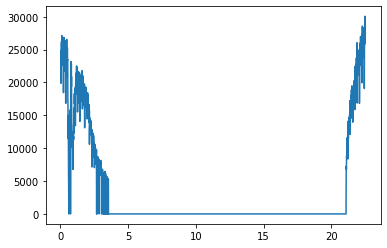

In [50]:
plt.plot(rt, ints)

Formula input module